In [1]:
!pip install stellargraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 435 kB 6.9 MB/s 


In [2]:
# Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd # Pandas to create small dataframes 
import numpy as np
import datetime # Convert to unix time
import time # Convert to unix time
# If numpy is not installed already : pip3 install numpy
import numpy as np # Do aritmetic operations on arrays
# Matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns # Plots
from matplotlib import rcParams # Size of plots  
import math
import pickle
import os
# To install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
from tqdm.notebook import tqdm
import random
from sklearn.model_selection import train_test_split
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint as sp_randint
from xgboost import XGBClassifier

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
data_path = "gdrive/My Drive/Twitch Link Prediction/ENGB/"

In [5]:
df_train = pd.read_csv(data_path+"engb_pos_train_91.csv")

In [6]:
df_train.head()

,Unnamed: 0,src,dest,link
0,6694,3609,2481,1
1,26453,3455,6007,1
2,13586,1598,2955,1
3,10649,1165,6920,1
4,4589,437,4983,1


In [7]:
import tensorflow

In [8]:
from stellargraph.core import StellarGraph
from stellargraph.mapper import AdjacencyPowerGenerator
from stellargraph.layer import WatchYourStep
from stellargraph.losses import graph_log_likelihood
from stellargraph.utils import plot_history

from tensorflow.keras import optimizers, Model, layers, regularizers
import tensorflow as tf

In [9]:
train_graph = nx.from_pandas_edgelist(df_train, source='src', target='dest', create_using=nx.MultiDiGraph())

In [10]:
G = StellarGraph.from_networkx(train_graph)

In [11]:
generator = AdjacencyPowerGenerator(G, num_powers = 3)

In [12]:
wys = WatchYourStep(
    generator,
    num_walks=80,
    embedding_dimension=64,
    attention_regularizer=regularizers.l2(0.5),
)
x_in, x_out = wys.in_out_tensors()

In [13]:
model = Model(inputs = x_in, outputs = x_out)
model.compile(loss=graph_log_likelihood, optimizer=tf.keras.optimizers.Adam(1e-2))

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor = 'loss',
    patience = 2,
    verbose = 1,
    restore_best_weights = True
)


In [15]:
epochs = 50
batch_size = 100
train_gen = generator.flow(batch_size=batch_size)
history = model.fit(
    train_gen, epochs=epochs, verbose=1, steps_per_epoch=int(len(G.nodes()) // batch_size), callbacks = [es]
)

Epoch 1/50
71/71 [==============================] - 12s 147ms/step - loss: 496429.2500
Epoch 2/50
71/71 [==============================] - 10s 141ms/step - loss: 328795.9375
Epoch 3/50
71/71 [==============================] - 10s 146ms/step - loss: 37249.0039
Epoch 4/50
71/71 [==============================] - 10s 144ms/step - loss: 16418.0410
Epoch 5/50
71/71 [==============================] - 10s 146ms/step - loss: 14857.0439
Epoch 6/50
71/71 [==============================] - 10s 144ms/step - loss: 14123.3428
Epoch 7/50
71/71 [==============================] - 14s 198ms/step - loss: 13559.5840
Epoch 8/50
71/71 [==============================] - 11s 152ms/step - loss: 13185.9551
Epoch 9/50
71/71 [==============================] - 11s 149ms/step - loss: 12921.1660
Epoch 10/50
71/71 [==============================] - 10s 138ms/step - loss: 12647.5137
Epoch 11/50
71/71 [==============================] - 10s 145ms/step - loss: 12404.0645
Epoch 12/50
71/71 [==============================]

In [16]:
model_file = open(data_path+"wys_model_91.h5", "wb")
pickle.dump(model, model_file)
model_file.close()

INFO:tensorflow:Assets written to: ram://2db896c2-4572-405c-a833-f26bcc46d0c1/assets


In [17]:
embeddings = wys.embeddings()

In [18]:
emb_file = open(data_path+"engb_wys_embeddings_91.pkl", "wb")
pickle.dump(embeddings, emb_file)
emb_file.close()

In [19]:
emb_file = open(data_path+"engb_wys_embeddings_91.pkl", "rb")
embeddings = pickle.load(emb_file)
emb_file.close()
embeddings.shape

(7126, 64)

In [20]:
nodes = list(G.nodes())
nodes[:5]

[3609, 2481, 3455, 6007, 1598]

In [21]:
emb_dict = {}
for i, node in enumerate(nodes):
  emb_dict[node] = np.array(embeddings[i].reshape(1,64))

In [22]:
combined_tr = pd.read_csv(data_path+"engb_train_91.csv", index_col = 0)
print(combined_tr.shape)
combined_tr.head()

(63351, 3)


,src,dest,link
3746,3387,512,0
32060,3625,2015,0
29151,4080,4876,1
8290,2633,6791,0
29003,4044,4799,1


In [23]:
# get training embeddings
train_emb = []
for i, row in tqdm(combined_tr.iterrows()):
  comb_emb = (emb_dict[row['src']]) * (emb_dict[row['dest']])
  train_emb.append(comb_emb[0])
train_emb = np.array(train_emb)

0it [00:00, ?it/s]

In [24]:
train_y = combined_tr['link']
len(train_y)

63351

In [25]:
combined_test = pd.read_csv(data_path+"engb_test_91.csv", index_col = 0)
combined_test.head()

,src,dest,link
17669,2061,2143,1
17352,2021,2450,1
26652,3499,4913,1
23292,1992,3967,0
4752,452,4671,1


In [26]:
# get test embeddings
test_emb = []
for i, row in tqdm(combined_test.iterrows()):
  comb_emb = (emb_dict[row['src']]) * (emb_dict[row['dest']])
  test_emb.append(comb_emb[0])

print(len(test_emb), len(test_emb[0]))
test_emb = np.array(test_emb)
print(test_emb.shape)
test_y = combined_test['link'] 

0it [00:00, ?it/s]

6973 64
(6973, 64)


In [27]:
#reading
from pandas import read_hdf
df_final_train = read_hdf(data_path + 'engb_fea_sample/engb_storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf(data_path + 'engb_fea_sample/engb_storage_sample_stage4.h5', 'test_df',mode='r')

In [28]:
df_final_train.columns

Index(['src', 'dest', 'link', 'jaccard_followers', 'jaccard_followees',
       'cosine_followers', 'cosine_followees', 'num_followers_s',
       'num_followers_d', 'num_followees_s', 'num_followees_d',
       'inter_followers', 'inter_followees', 'adar_index', 'follows_back',
       'same_comp', 'shortest_path', 'weight_in', 'weight_out', 'weight_f1',
       'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d',
       'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'svd_dot_u', 'svd_dot_v', 'pref_attach_er', 'pref_attach_ee'],
      dtype='object')

In [29]:
df_final_train.shape

(63351, 59)

In [30]:
y_train = df_final_train.link
y_test = df_final_test.link

In [31]:
df_final_train.drop(['src', 'dest','link'],axis=1,inplace=True)
df_final_test.drop(['src', 'dest','link'],axis=1,inplace=True)

In [32]:
# WYS only
clf = XGBClassifier(max_depth=7, n_estimators=100, n_jobs=-1,
              random_state=25)
clf.fit(train_emb, train_y)
train_sc = f1_score(train_y,clf.predict(train_emb))
test_sc = f1_score(test_y,clf.predict(test_emb))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.8708395191801158 test Score 0.7667616619169042


In [33]:
# WYS only
clf = RandomForestClassifier(max_depth=12, n_estimators=100, n_jobs=-1,
              random_state=25)
clf.fit(train_emb, train_y)
train_sc = f1_score(train_y,clf.predict(train_emb))
test_sc = f1_score(test_y,clf.predict(test_emb))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.8911472375999108 test Score 0.7608180201541197


In [34]:
# WYS only
from lightgbm import LGBMClassifier
clf = LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, 
                     objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, 
                     subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=- 1, importance_type='split')
clf.fit(train_emb, train_y)
train_sc = f1_score(train_y,clf.predict(train_emb))
test_sc = f1_score(test_y,clf.predict(test_emb))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.8361165606009857 test Score 0.762602842183994


In [35]:
# Heuristic only
clf = XGBClassifier(max_depth=7, n_estimators=100, n_jobs=-1,
              random_state=25)
clf.fit(df_final_train,y_train)
train_sc = f1_score(y_train,clf.predict(df_final_train))
test_sc = f1_score(y_test,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9727737078054952 test Score 0.74853195164076


In [36]:
# Heuristic only
clf = RandomForestClassifier(max_depth=12, n_estimators=100, n_jobs=-1,
              random_state=25)
clf.fit(df_final_train,y_train)
train_sc = f1_score(y_train,clf.predict(df_final_train))
test_sc = f1_score(y_test,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9666640764628177 test Score 0.7794803464357095


In [37]:
# Heuristic only
clf = LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, 
                     objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, 
                     subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=- 1, importance_type='split')
clf.fit(df_final_train,y_train)
train_sc = f1_score(y_train,clf.predict(df_final_train))
test_sc = f1_score(y_test,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9737882742774974 test Score 0.7443791075752335


In [38]:
df_final_train = np.hstack((df_final_train, train_emb))
print(df_final_train.shape)
df_final_test = np.hstack((df_final_test, test_emb))
print(df_final_test.shape)

(63351, 120)
(6973, 120)


In [39]:
print(type(train_y), type(y_train))
for i in range(len(y_train.values)):
  if train_y.values[i] != y_train.values[i]: print(i)

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [40]:
# Heuristic + WYS
clf = XGBClassifier(max_depth=7, n_estimators=100, n_jobs=-1,
              random_state=25)
clf.fit(df_final_train,y_train)
train_sc = f1_score(y_train,clf.predict(df_final_train))
test_sc = f1_score(y_test,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9782574739933148 test Score 0.7526216262678357


In [41]:
# Heuristic + WYS
clf = RandomForestClassifier(max_depth=12, n_estimators=100, n_jobs=-1,
              random_state=25)
clf.fit(df_final_train,y_train)
train_sc = f1_score(y_train,clf.predict(df_final_train))
test_sc = f1_score(y_test,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9673354747606412 test Score 0.7924651924651925


In [42]:
# Heuristic + WYS
clf = LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, 
                     objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, 
                     subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=- 1, importance_type='split')
clf.fit(df_final_train,y_train)
train_sc = f1_score(y_train,clf.predict(df_final_train))
test_sc = f1_score(y_test,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9780946573479057 test Score 0.747750865051903


In [43]:
%%time
clf = LGBMClassifier(learning_rate=0.01, max_depth=15, n_estimators=160, random_state=25)
clf.fit(df_final_train, train_y)
train_sc = f1_score(train_y,clf.predict(df_final_train))
test_sc = f1_score(test_y,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9590825516532144 test Score 0.7542445549648432
CPU times: user 23.8 s, sys: 125 ms, total: 23.9 s
Wall time: 12.4 s


In [44]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [45]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

Train confusion_matrix


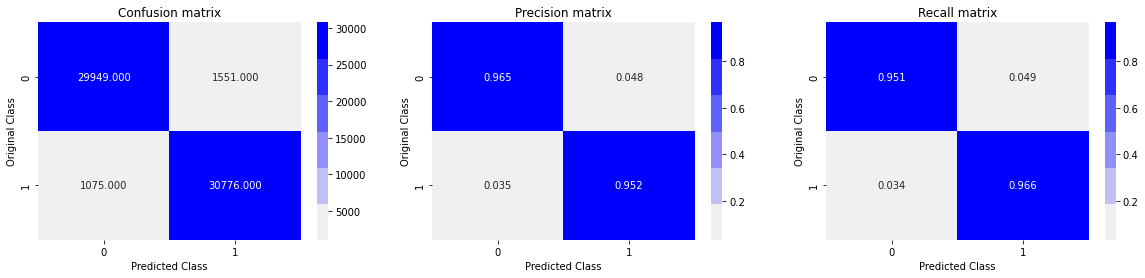

Test confusion_matrix


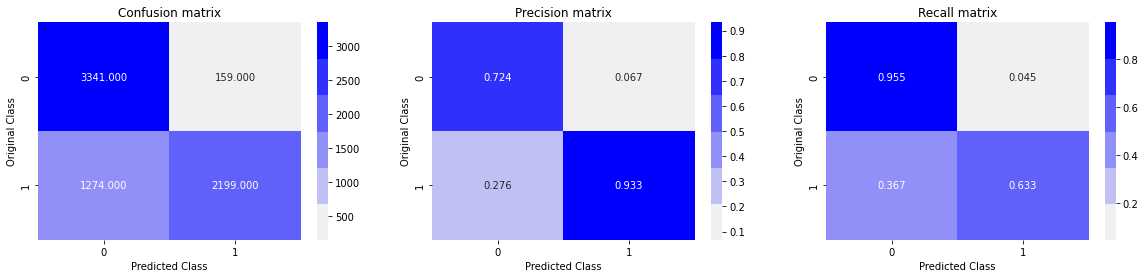

In [46]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

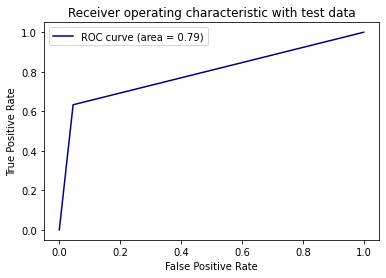

In [47]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

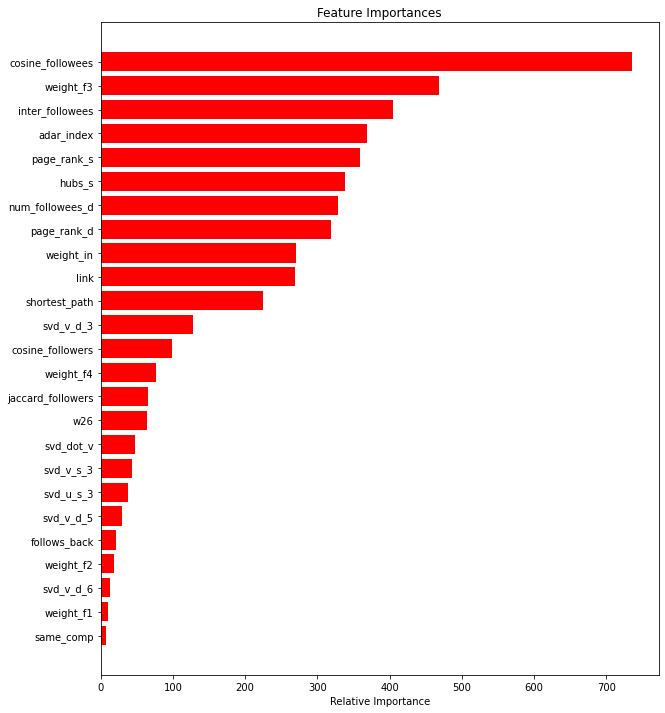

In [48]:
features = ['src', 'dest', 'link', 'jaccard_followers', 'jaccard_followees',
       'cosine_followers', 'cosine_followees', 'num_followers_s',
       'num_followers_d', 'num_followees_s', 'num_followees_d',
       'inter_followers', 'inter_followees', 'adar_index', 'follows_back',
       'same_comp', 'shortest_path', 'weight_in', 'weight_out', 'weight_f1',
       'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d',
       'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'svd_dot_u', 'svd_dot_v', 'pref_attach_er', 'pref_attach_ee'] + ['w' + str(i) for i in range(1, 65)]

importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()